# Notebook for crowdsourcing experiments for ChartFC Wikicommons dataset

## Overview 
This notebook executes the crowdsourcing experiments for the three different tasks 


1. <strong>Generate tasksets </strong>


2. <strong>Label gold tasks </strong>


3. <strong>Sent tasks to Mechanical Turk for annotation</strong> 


4. <strong>Frequently update task with workers' answers</strong> 

Set the following constants first:


#### Importing packages

In [1]:
# Load packages 

import bs4 
import boto3
import botocore
import botocore.exceptions
import copy
# import dns
import json
import certifi

import numpy as np
import os
import pandas as pd
import pymongo
import random
import requests
import uuid

from bs4 import BeautifulSoup
from collections import OrderedDict
from datetime import datetime
from pprint import pprint
from pymongo import MongoClient, InsertOne
import pdb

from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
import math
import xmltodict

random.seed(10)


In [2]:
# VARIABLES 

PROJECT_PATH = r"/Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons"

# Folder containing all data files for crowdsourcing
DATA_FOLDER = os.path.join(PROJECT_PATH, 'data')

# Folder containing all config files for crowdsourcing
CONFIG_FOLDER = os.path.join(PROJECT_PATH, 'config')
TASK_CONFIG = os.path.join(CONFIG_FOLDER, 'task_config_{}.json') 

# Set path to .json file with crowdsourcing qualification tests
PATH_QUALIFICATION_TESTS = os.path.join(PROJECT_PATH, 'data/mturk/qualification_tests.json')

# Set task type as one of the following: 'table_annotation', 'claim_generation', 'adjusted_claim_annotation'
TASK_TYPE_LIST = ["chart_filtering", "claim_explanation_generation", "claim_explanation_verification", "explanation_verification"]
TASK_TYPE = TASK_TYPE_LIST[2] # selected task type

# Set to 1 if crowdsourcing tasks in production should be created, else 0 for test
CREATE_HITS_IN_PRODUCTION = 1 # !!! DONT CHANGE THIS 

# Set 1 if current taskSet (if existing) should be updated
UPDATE_TASKSETS_CHART_FILTERING = 0
UPDATE_TASKSETS_CLAIM_EXPLANATION_GENERATION = 0

# Set path to db credentials, used for storing crowdsourcing tasks and results 
PATH_MONGODB_CREDENTIALS = os.path.join(PROJECT_PATH, 'config/mongodb_credentials.json')

# Set path to amazon credentials saved in a .json file
PATH_AMAZON_CREDENTIALS = os.path.join(PROJECT_PATH, 'config/amazon_credentials.json')

# Set Amazon mturk endpoint used for crowdsourcing experiments
MTURK_ENDPOINT = 'https://mturk-requester.us-east-1.amazonaws.com'
MTURK_ENDPOINT_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'

WORKER_BAN_LIST = os.path.join(PROJECT_PATH, f'config/banlist_{TASK_TYPE}.json')

# Path to save created tasks for a task 
PATH_TASKSETS_FOLDER = os.path.join(DATA_FOLDER, "mturk", "tasksets")
PATH_PRE_TASKSETS = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets.json")
PATH_PRE_TASKSETS_GOLD = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets_gold.json")
PATH_PRE_TASKSETS_NON_GOLD = os.path.join(PATH_TASKSETS_FOLDER, "{}_pre_tasksets_non_gold.json")
PATH_TASKSETS = os.path.join(PATH_TASKSETS_FOLDER, "{}_tasksets.json")

# Paths to html files
PATH_HTML_TEXT = os.path.join(DATA_FOLDER, "mturk", "html_text")
PATH_HTML_TEMPLATE = os.path.join(PROJECT_PATH, "code", "html_files")


In [53]:
# Ban workers which are spammers after pilot round 

to_ban = True
if to_ban:
    with open(WORKER_BAN_LIST,'r') as f:
        banlist = json.load(f)
    for w in banlist:
        try:
            print(w)
            response = mt.client.create_worker_block(WorkerId=w, Reason='Malicious behaviour.')
            assert(response['ResponseMetadata']['HTTPStatusCode'] == 200)
        except botocore.exceptions.ClientError as e:
            print(f"Following exception thrown ", e)
            continue
    print(f"{len(banlist)} workers banned in total.")
    
else: 
    print("No worker banned.")
            

A2YDW8YH92OTMJ
AHIEGG1CIF8HI
A2E01QC59QLRV0
A2YDW8YH92OTMJ
A1BX9HAQ85WQV1
A1AOOWER2J623J
A16MEV9DI9VMAW
A32YOD79DL837P
A2Z0OH990725SA
ASLGN9PS93UYR
A2JXPT39AWRES7
A2U1H2N3QC647R
12 workers banned in total.


---------------

In [ ]:
db = db_client['pubhealth']


---------------

In [4]:
with open(PATH_QUALIFICATION_TESTS,'r') as f:
    qualification_tests = json.load(f)


In [5]:
# MongoDB connection

with open(PATH_MONGODB_CREDENTIALS,'r') as f:
    mongodb_credentials = json.load(f)

# Connect to Mong\oDB
db_client = pymongo.MongoClient(mongodb_credentials["connection_string"], tlsCAFile=certifi.where()) # connecting to database
db = db_client['chartfc']


In [6]:
# select dataset table to save results 

if TASK_TYPE == "chart_filtering": 
    hit_result_collection = db.hit_results if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox
elif TASK_TYPE == "claim_explanation_generation": 
    hit_result_collection = db.hit_results_claim_explanation_generation if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox_claim_explanation_generation
elif TASK_TYPE == "claim_explanation_verification":
    hit_result_collection = db.hit_results_claim_explanation_verification if CREATE_HITS_IN_PRODUCTION else db.hit_results_sandbox_claim_explanation_verification
    

In [7]:
# Mturk client

class MTurk():

    def __init__(self):
        with open(PATH_AMAZON_CREDENTIALS)  as f: # get the credentials from AMT 
            cfg = json.load(f)

        self.access_key = cfg['access_key']
        self.secret_key = cfg['secret_key']
        
        self.environments = {
            "production": {
                "endpoint": MTURK_ENDPOINT, # set mturk endpoint
                "preview": "https://www.mturk.com/mturk/preview"
            },
            "sandbox": {
                "endpoint": MTURK_ENDPOINT_SANDBOX, # set mturk endpoint
                "preview": "https://workersandbox.mturk.com/mturk/preview"
            },
        }

    def launch_client(self, production = False):
        self.mturk_environment = self.environments["production"] if production else self.environments["sandbox"]
        try:
            session = boto3.Session(profile_name='mturk')
        except botocore.exceptions.ProfileNotFound as e:
            session = boto3.Session(
                profile_name='mturk',
                aws_access_key_id  = self.access_key,
                aws_secret_access_key  = self.secret_key
            )
        self.client = session.client(
            service_name= 'mturk',
            region_name= 'us-east-1',
            endpoint_url= self.mturk_environment['endpoint'],
        )
        print(self.client.get_account_balance()['AvailableBalance'])

    def create_hit(self, html_layout, **TaskAttributes):
        QUESTION_XML = """<HTMLQuestion xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2011-11-11/HTMLQuestion.xsd"><HTMLContent><![CDATA[{}]]></HTMLContent><FrameHeight>650</FrameHeight></HTMLQuestion>"""
        question_xml = QUESTION_XML.format(html_layout)
        
#         print(f"question_xml: {question_xml}")
        
        try:
            response = self.client.create_hit(
            **TaskAttributes,
                Question=question_xml
            )
        except Exception:
            with open('question_debug.xml','w+') as f:
                f.write(question_xml)
            print(f"question_xml is {question_xml}.")
            raise

        return response
    
    def get_hit_status(self, HITId):
        hit = self.client.get_hit(HITId=HITId)
        hit_status = hit['HIT']['HITStatus']
        return hit_status

    def get_hit_answers(self, HITId, approve=False):

        # Get list and number of Assignments that have been completed
        hit_assignmentsList = self.client.list_assignments_for_hit(
            HITId=HITId,
            AssignmentStatuses=['Submitted','Approved']
        )

        assignments = hit_assignmentsList['Assignments']

        # Get details and results of each Assignment and add to answers array
        answers = []
        for assignment in assignments:
            worker_id = assignment['WorkerId']
            assignment_id = assignment['AssignmentId']

            answer_dict = xmltodict.parse(assignment['Answer'])['QuestionFormAnswers']['Answer']
            values = {}
            for entry in answer_dict:
                try:
                    values[entry['QuestionIdentifier']] = json.loads(entry['FreeText'])
                except ValueError:
                    values[entry['QuestionIdentifier']] = entry['FreeText']
                except TypeError:
                    values[entry['QuestionIdentifier']] = None

            answer = {
                'worker_id' : worker_id,
                'assignment_id' : assignment_id,
                'values' : values,
                'HITId' : HITId
            }
            answers.append(answer)
            
            if approve:
                # Approve or not assignments
                if assignment['AssignmentStatus'] == 'Submitted':
                    self.client.approve_assignment(
                        AssignmentId = assignment_id,
                        OverrideRejection = False
                    )
                    
        return answers

In [52]:
# Connect to MTurk

mt = MTurk()
mt.launch_client(production = CREATE_HITS_IN_PRODUCTION)


4516.28


### Functions 


In [10]:
maxSingleInstances = 1 # MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS

def get_random_task(counter, n, non_gd_tasks):
    """Returns n random tasks of format (task, index) from list non_gd_tasks"""
    
    task_seq = []
    p = [max(maxSingleInstances-c,0.0001) for c in counter] # indexes of samples which can be used for task generation 
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice( # random choice of entries (given some constraints)
        a = list(range(len(non_gd_tasks))),
        size=n,
        replace=False, 
        p=p # samples used before in other tasks => probability set to 0 so that they are not chosen twice
    )        

    for i in indexes:
        task = non_gd_tasks[i]
        task_seq.append((task,i))
    
    return task_seq


def get_random_gd_task(n, gd_tasks):
    """Returns a sub-list of gd_tasks (ground truth) with n entries"""
    return random.sample(gd_tasks, n)


def generate_taskset(counter, non_gd_tasks, gd_tasks, n=(5,2)): # set the number of non-gold labelled tasks (e.g. 5) and gold labelled task (e.g. 2)
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    
    task = get_random_task(counter, n[0], non_gd_tasks) # returns list of (index, sample)
    taskSet = [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    taskSet.extend(get_random_gd_task(n[1], gd_tasks))
    
    random.shuffle(taskSet) # gold standard should occur anywhere
    
    return taskSet, [i for (p,i) in task] # indixes returned to update counter


def generate_taskset_no_gold(counter, non_gd_tasks, n=5):
    """
    Generates taskset of n (default = 5) tasks and updates counter,
    so that a task appears only 'maxSingleInstances'-times in a taskSet
    """
    task_index_set = get_random_task(counter, n, non_gd_tasks) # returns list of (index, sample)
    taskSet = [r for (r,i) in task_index_set] # tasks extracted from the pairs of (task, index)
    
    return taskSet, [i for (p,i) in task_index_set] # indixes returned to update counter


def generate_taskset_w_ids(non_gd_tasks, gd_tasks, non_gold_per_taskset, gold_per_taskset) -> list:
    """
    Function to generate TaskSets given gold standards and other samples 
    """
    taskSets = []
    counter = [0]*len(non_gd_tasks) # keeping track if sample has been used before 

    while (any([c < maxSingleInstances for c in counter])):
        # generate task set with some random samples
        taskSet, indexes = generate_taskset(counter, non_gd_tasks, gd_tasks, n=(non_gold_per_taskset, gold_per_taskset)) 
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd) # add created taskSet with ID to list of taskSets 
        for i in indexes:
            # increase counter for samples added, so that they only appear 'maxSingleInstances'-times in a taskSet
            counter[i] = counter[i] + 1 
    
    return taskSets, counter


def generate_taskset_w_ids_no_gold(non_gd_tasks, n = 5) -> list:
    """
    Function to generate TaskSets given samples but without gold labelled samples 
    n (int): number of non_gold entries per taskSet
    """
    task_set_list = []
    counter = [0]*len(non_gd_tasks) # keeping track if sample has been used before 

    while (any([c < maxSingleInstances for c in counter])): # iterate as long as any sample in non_gd_tasks as not been used
        # generate task set with some random samples
        task_set, indexes = generate_taskset_no_gold(counter, non_gd_tasks, n) 
        task_set_w_id = {
            '_id': str(uuid.uuid4()),
            'taskSet' : task_set
        }
        
        task_set_list.append(task_set_w_id) # add created taskSet with ID to list of taskSets 
        for i in indexes:
            # increase counter for samples added, so that they only appear 'maxSingleInstances'-times in a taskSet
            counter[i] = counter[i] + 1 
    
    return task_set_list, counter
    

### 1. Generation of task sets


In [11]:
# Load data from MongoDB database for taskset creation

db_table = pd.DataFrame()

if TASK_TYPE == "chart_filtering": 
    db_table = db.chart_filtering
    cursor = db_table.find({"type": {"$regex": "(line_chart|pie_chart|barchart_vertical|barchart_horizontal)"}})# exclude scatterplots
    db_table = pd.DataFrame(list(cursor))
elif TASK_TYPE == "claim_explanation_generation": 
    db_table = db.chart_filtering
    cursor = db_table.find({"type": {"$regex": "(line_chart|pie_chart|barchart_vertical|barchart_horizontal)"},
                            "chart_filter_majority": 5
                           })# exclude scatterplots
    db_table = pd.DataFrame(list(cursor))
elif TASK_TYPE == "claim_explanation_verification": 
    db_table = db.hit_results_claim_explanation_generation
    cursor = db_table.find({'$or': [{'answers': {'$size': 1}}, {'answers': {'$size': 2}}, {'answers': {'$size': 3}}]})
    db_table = pd.DataFrame(list(cursor))
else:
    print(f"No table for task type {TASK_TYPE}")
    
print(f"Length of retrieved table: {len(db_table)}")

db_table.head(3)


Length of retrieved table: 576


_id                              batch_id  \
0  3PIOQ99R85KXJS7404KD8AU0849UNP  6d04f1db-91a4-44ae-a4b6-094bc769ffb3   
1  3PA41K45WU2VO27L3B4U27LB0937PO  00a7b61c-7975-4492-bc1b-0e322df899c2   
2  3VO4XFFP2CKGOE803OJJ2CBL55P7QF  00a7b61c-7975-4492-bc1b-0e322df899c2   

                           type  \
0  claim_explanation_generation   
1  claim_explanation_generation   
2  claim_explanation_generation   

                                          references  \
0  [{'db_id': '6390687199c9ed38aa871079', 'chart_...   
1  [{'db_id': '6390687199c9ed38aa870fb1', 'chart_...   
2  [{'db_id': '6390685299c9ed38aa870b3b', 'chart_...   

                             taskSet_id  \
0  9899f1d9-8f33-4d90-a601-93772a258e8c   
1  b328066e-054f-45fd-b0e0-32ca6e54ae32   
2  09c75ca1-15b0-4ff3-85d8-540227de087a   

                                                 hit               timestamp  \
0  {'HITId': '3PIOQ99R85KXJS7404KD8AU0849UNP', 'H... 2023-03-28 17:30:06.785   
1  {'HITId': '3PA41K45WU2VO27L3B4U27LB0937PO', 'H... 2023-03-29 09:41:31.100   
2  {'HITId': '3VO4XFFP2CKGOE803OJJ2CBL55P7QF', 'H... 2023-03-29 09:41:32.643   

                                             answers  
0  [{'worker_id': 'A1PZ6FQ0WT3ROZ', 'assignment_i...  
1  [{'worker_id': 'AFHD81VGCBAUJ', 'assignment_id...  
2  [{'worker_id': 'A3CCFD0700KTPV', 'assignment_i...

In [12]:
def create_tasks_chart_filtering(df): 
    """
    Function to create task set for the task chart filtering 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "g_id": -1 # groundtruth id only -1 if this is a gold sample 
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        task = copy.deepcopy(task_template)
        task["db_id"] = str(row["_id"])
        task["caption"] = row["description"]
        task["chart_img"] = task["chart_img"].format(title = row["file_name"])
        if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
            task["chart_img"] = task["chart_img"].replace("%", "%25")
        task_list.append(task)
        
    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


def create_tasks_claim_explanation_generation(df): 
    """
    Function to create task set for the task claim_explanation_generation 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "support_claim": -1,
        "support_explanation": -1,
        "refute_claim": -1,
        "refute_explanation": -1,
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        task = copy.deepcopy(task_template)
        task["db_id"] = str(row["_id"])
        task["caption"] = row["description"]
        task["chart_img"] = task["chart_img"].format(title = row["file_name"])
        if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
            task["chart_img"] = task["chart_img"].replace("%", "%25")
        task_list.append(task)
        
    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


def create_tasks_claim_explanation_verification(df): 
    """
    Function to create task set for the task claim_explanation_verification 
    df: database table for which to create task sets
    """
    
    # template for chart filtering tasks
    task_template = {
        "db_id": "",
        "chart_img": "https://chartfc.s3.amazonaws.com/{title}",
        "caption": "",
        "label": -1,
        "claim": -1,
        "explanation": -1,
        "claim_rewritten": -1,
        "explanation_rewritten": -1,
        "claim_error_corrected": -1,
        "explanation_error_corrected": -1,
        "label_claim": -1,
        "label_explanation": -1,
        "g_id_claim": -1, 
        "g_id_explanation": -1 
    }
    
    task_list = []
    # Iterate over data in df and create task sets
    for index, row in df.iterrows():
        for answer in row["answers"]:
            for i, output in enumerate(answer["values"]["outputs"]):
                # support claim
                task = copy.deepcopy(task_template)
                task["db_id"] = str(row["_id"])
                task["caption"] = row["references"][i]["caption"]
                task["chart_img"] = row["references"][i]["chart_img"]
                if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
                    task["chart_img"] = task["chart_img"].replace("%", "%25")
                
                task["label"] = "support"
                task["claim"] = output["claim_text_support"]
                task["explanation"] = output["explanation_claim_text_support"]
                task_list.append(task)

                # refute claim
                task = copy.deepcopy(task_template)
                task["db_id"] = str(row["_id"])
                task["caption"] = row["references"][i]["caption"]
                task["chart_img"] = row["references"][i]["chart_img"]
                if "%" in task["chart_img"]: # img url has "%" sign => replace by "%25"
                    task["chart_img"] = task["chart_img"].replace("%", "%25")

                task["label"] = "refute"
                task["claim"] = output["claim_text_refute"]
                task["explanation"] = output["explanation_claim_text_refute"]
                task_list.append(task)

    print(f"{len(task_list)} tasks in total created.\n")
    return task_list


In [13]:
# Create and save tasks for CHART FILTERING
CREATE_AND_SAVE_TASKS = 0
path = PATH_PRE_TASKSETS.format(TASK_TYPE)

if CREATE_AND_SAVE_TASKS and TASK_TYPE == "chart_filtering": 
    chart_filtering_tasks = create_tasks_chart_filtering(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(chart_filtering_tasks, file, indent=4, ensure_ascii=False)
        
elif CREATE_AND_SAVE_TASKS and TASK_TYPE == "claim_explanation_generation": 
    claim_explanation_generation_tasks = create_tasks_claim_explanation_generation(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(claim_explanation_generation_tasks, file, indent=4, ensure_ascii=False)
        
elif CREATE_AND_SAVE_TASKS and TASK_TYPE == "claim_explanation_verification": 
    claim_explanation_verification_tasks = create_tasks_claim_explanation_verification(db_table)
    print(f"Saving generated task list at path {path}.\n")

    with open(path, "w", encoding="utf-8") as file:
        json.dump(claim_explanation_verification_tasks, file, indent=4, ensure_ascii=False)
else:
    print(f"Loading generated task list from path {path}.\n")
    
    with open(path, "r", encoding="utf-8") as file:
        chart_filtering_tasks = json.load(file)


Loading generated task list from path /Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons/data/mturk/tasksets/claim_explanation_verification_pre_tasksets.json.



### Split tasks in gold and non-gold samples

In [14]:
CREATE_AND_SAVE_GOLD = 0

if CREATE_AND_SAVE_GOLD:
    golden_standard_quota = 50 # number of gold tasks we want

    with open(PATH_PRE_TASKSETS.format(TASK_TYPE), "rb") as file: 
        task_list = json.load(file)

    # shuffle list to select gold standards randomly 
    random.shuffle(task_list)

    # save tasks for ground truth labelling 
    with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
        json.dump(task_list[:golden_standard_quota], file, indent=4, ensure_ascii=False)

    # save other tasks seperately
    with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
        json.dump(task_list[golden_standard_quota:], file, indent=4, ensure_ascii=False)
else: 
    print("Info: Gold already created and labelled, not creating again")

Info: Gold already created and labelled, not creating again


In [15]:
# # delete all gold annotated from non-gold
# with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'r', encoding='utf8') as file:
#     non_gold = json.load(file)
        
# with open(r"C:\Users\k20116188\PycharmProjects\chartfc_dataset_wikicommons\data\mturk\tasksets\chart_filtering_pre_tasksets_gold_annotated.json", 'r', encoding='utf8') as file:
#     gold_annotated = json.load(file)

# db_list_gold = [entry["db_id"] for entry in gold_annotated]

# non_gold_filtered_entries = []
# for entry in non_gold: 
#     if entry["db_id"] in db_list_gold:
#         continue
#     non_gold_filtered_entries.append(entry)
    

In [16]:
# with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), 'w+', encoding='utf8') as file:
#     json.dump(non_gold_filtered_entries, file, indent=4, ensure_ascii=False)

### TODO (!): Before next step: manually set gold labels in task_list_gold.json

#### Generating tasksets of 7 tasks each (two out of them are gold standards)

In [17]:
CREATE_AND_SAVE_TASKSETS = 0

if CREATE_AND_SAVE_TASKSETS:
    if TASK_TYPE == "chart_filtering":
        # load task list of gold standards
        with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_gold = json.load(file) 

        # load non gold standard task list
        with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_non_gold = json.load(file) 

        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list_non_gold, task_list_gold, non_gold_per_taskset=5, gold_per_taskset=2)

        print(f"{len(task_sets)} tasksets created out of {len(task_list_gold)} gold tasks and {len(task_list_non_gold)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
            
    elif TASK_TYPE == "claim_explanation_generation": 
        # load pre tasksets
        with open(PATH_PRE_TASKSETS.format(TASK_TYPE), "rb") as file: 
            task_list = json.load(file)
            
        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list, [], non_gold_per_taskset=5, gold_per_taskset=0)

        print(f"{len(task_sets)} tasksets created out of {0} gold tasks and {len(task_list)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
            
    elif TASK_TYPE == "claim_explanation_verification": 
        # load task list of gold standards
        with open(PATH_PRE_TASKSETS_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_gold = json.load(file) 

        # load non gold standard task list
        with open(PATH_PRE_TASKSETS_NON_GOLD.format(TASK_TYPE), "rb") as file: 
            task_list_non_gold = json.load(file) 
            
        print("data loaded..")
            
        # set number of non-gold tasks to use accord. to how many labelled gold we have
        task_sets, counter = generate_taskset_w_ids(task_list_non_gold, task_list_gold, non_gold_per_taskset=5, gold_per_taskset=2)

#         print(f"{len(task_sets)} tasksets created out  of {len(task_list_gold)} gold tasks and {len(task_list)} non-gold tasks.")

        # save tasksets 
        with open(PATH_TASKSETS.format(TASK_TYPE), 'w+', encoding='utf8') as file:
            json.dump(task_sets, file, indent=4, ensure_ascii=False)
else: 
    print(f"Loading taskset from path {PATH_TASKSETS.format(TASK_TYPE)}.")

    with open(PATH_TASKSETS.format(TASK_TYPE), 'r', encoding='utf8') as file:
        task_sets = json.load(file)
        
# NEEDED LATER FOR CLAIM WRITING TASKS 

# elif update_tasksets and task_type == "claim_generation":
#     with open(os.path.join(data_folder, "TaskSets/pre_tasksets_{}.json".format(task_type)), "rb") as file: 
#         task_list_non_gold = json.load(file)
    
#     task_sets, counter = generate_taskset_w_ids_no_gold(task_list_non_gold, n = 5)
#     print(f"{len(task_sets)} tasksets created out of {len(task_list_non_gold)} non-gold tasks.")
    
#     # save tasksets 
#     with open(os.path.join(data_folder, "TaskSets/tasksets_{}.json".format(task_type)), 'w+', encoding='utf8') as file:
#         json.dump(task_sets, file, indent=4, ensure_ascii=False)


Loading taskset from path /Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons/data/mturk/tasksets/claim_explanation_verification_tasksets.json.


### 2. Running Crowdsourcing

In [60]:
# Functions to preprocess tables for displaying in annotation UI
        
def taskset_tostring(taskSet_list: list): 
    """
    Covert taskset to string to send to MTurk 
    """    
    result_str = str(taskSet_list).replace("\'caption\': None", "\'caption\': \'no caption given\'")
    result_str = result_str.encode('ascii', 'ignore').decode('ascii')

    return result_str


In [61]:
# Loading task config to create MTurk tasks

""" Create the tasks by populating the HTML templates using the config file """

with open(TASK_CONFIG.format(TASK_TYPE),'r') as f: # load config file with worker qualifications, location, etc. 
    task_temp = json.load(f)
    
taskSets_all_lan = {}

task_content = copy.deepcopy(task_temp)
TaskAttributes = task_content['task_attributes']


In [62]:
# Prepare HTML page 

html_layout = open(os.path.join(PATH_HTML_TEMPLATE, task_content['html_layout']), 'r').read()

with open(os.path.join(PATH_HTML_TEXT, task_content['instructions_project_text_file']),'r') as f:
    task_content['instructions_project_text'] = f.read().replace('\n',' ')
    
with open(os.path.join(PATH_HTML_TEXT, task_content['instructions_rules_text_file']),'r') as f:
    task_content['instructions_rules_text'] = f.read().replace('\n',' ')

# enter instruction texts in the html template 
html_layout = html_layout.\
    replace('${instructions_project_text}$', task_content['instructions_project_text']).\
    replace('${instructions_rules_text}$', task_content['instructions_rules_text']).\
    replace('${time_thr}$', task_content['time_thr'])

print(os.path.join(PATH_TASKSETS_FOLDER, task_content['tasks']))
with open(os.path.join(PATH_TASKSETS_FOLDER, task_content['tasks']),'r', encoding='utf8') as f:
    taskSets = json.load(f)

# If you're only testing, just pick one hit and run it once, with no qualification barriers
if not CREATE_HITS_IN_PRODUCTION:
    TaskAttributes.pop('QualificationRequirements')
    TaskAttributes['MaxAssignments'] = 1 
    random.seed(2)
#     taskSets = random.sample(taskSets,5)
else:
    pass
#     random.seed(42)
#     taskSets = random.sample(taskSets,200)  

print('Generated {} tasks with the following configs:'.format(len(taskSets)))
pprint(TaskAttributes, indent=1) #verify the properties before running the HITs
print('')


/Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons/data/mturk/tasksets/claim_explanation_verification_tasksets.json
Generated 1852 tasks with the following configs:
{'AssignmentDurationInSeconds': 3600,
 'Description': 'This is a pilot study, so useful feedback is rewarded.',
 'Keywords': 'chart images, fact checking, text verification',
 'LifetimeInSeconds': 604800,
 'MaxAssignments': 3,
 'QualificationRequirements': [{'ActionsGuarded': 'DiscoverPreviewAndAccept',
                                'Comparator': 'GreaterThanOrEqualTo',
                                'IntegerValues': [95],
                                'QualificationTypeId': '000000000000000000L0'},
                               {'ActionsGuarded': 'DiscoverPreviewAndAccept',
                                'Comparator': 'GreaterThan',
                                'IntegerValues': [1000],
                                'QualificationTypeId': '000000000000000000

In [63]:
# Extract taskSets not already in db table "hit_results"
# query = {'answers': {'$size': 2}}
query = {}
# projection = {'taskSet_id': 1}
projection = {}

hit_result_collection_list = list(hit_result_collection.find(query, projection))
hit_result_collection_list_ids = [entry['taskSet_id'] for entry in hit_result_collection_list]

taskSets_filtered = [entry for entry in taskSets if entry['_id'] not in hit_result_collection_list_ids]
# taskSets_filtered = taskSets

In [64]:
len(taskSets_filtered)

1580

In [65]:
# Creating hits and saving in MongoDb with HIT_ID
# later based on the HIT_ID the results are updated

""" Create the batch of HITs """

results = []
batch_id = str(uuid.uuid4())
hit_type_id = ''
target_assignments = TaskAttributes['MaxAssignments']

# Reannotation 2nd task: till 200 done

for taskSet in taskSets_filtered[:50]: 
    TaskAttributes_hit = copy.deepcopy(TaskAttributes) # Adjust based on how many were already done in other batches
    TaskAttributes_hit['MaxAssignments'] = target_assignments -\
        sum([hit['hit']['NumberOfAssignmentsCompleted'] for hit in hit_result_collection.find({
            'taskSet_id':taskSet['_id'],
            'type': task_content['type']
        })])
#     if TaskAttributes_hit['MaxAssignments'] > 0:
    random.seed(None)
    qualification_questions = random.sample(qualification_tests, k=3) # Adjust with table questions
    try:
        html_layout_replaced = html_layout.replace('${references}$', taskset_tostring(taskSet['taskSet'])).\
                                replace('${qualification_questions}$', json.dumps(qualification_questions))

        response = mt.create_hit(html_layout_replaced, **TaskAttributes_hit)

    except Exception as e: 
        print(f"Exception occurred, continue with next entry in TaskSets: {e}\n")
        pdb.set_trace()            
        raise
        continue 

    hit_type_id = response['HIT']['HITTypeId']
    result = {
        '_id': response['HIT']['HITId'],
        'batch_id': batch_id,
        'type': task_content['type'],
        'references': taskSet['taskSet'],
        'taskSet_id':taskSet['_id'],
        'hit': response['HIT'],
        'timestamp': datetime.now()
    }
    results.append(result)
    try:
        hit_result_collection.insert_one(result) # ADD hit with ID returned from AMT to my MongoDB database
    except Exception:
        print(result)
#             raise

# For you to go to the HITs you just created and test them
print('Launched tasks for chart fact checking')
if not CREATE_HITS_IN_PRODUCTION:
    print('You can view the HITs here:')
    print(mt.mturk_environment['preview']+"?groupId={}".format(hit_type_id))
else:
    print('Launched! Good Luck!')


{'_id': '3S1L4CQSG431GRGPWBK9049XZ8EFA6', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '39KMGHJ4S68EIA3H1R4V8RAGKZ600J', 'chart_img': 'https://chartfc.s3.amazonaws.com/MaxMind_Country_Geocode_Error_Rate_Versus_DB_Months_Out_of_Date.png', 'caption': 'The fraction of page requests which are geocoded as different countries between the most recent MaxMind database and the most recent MaxMind database as of N months ago.', 'label': 'FALSE', 'claim': 'The fraction of page requests which are geocoded as different countries between the most recent MaxMind database and', 'explanation': 'The fraction of page requests which are geocoded as different countries between the most recent MaxMind database and', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3B0MCRZMCY

{'_id': '3ATYLI1PS006NXWMPKGCGXLUHWZJOC', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3M47JKRKD4ZREAUZYKXRA7QPGVD68C', 'chart_img': 'https://chartfc.s3.amazonaws.com/Power_Conversion_Efficiency.jpg', 'caption': 'Comparison of the general power conversion efficiency of different types of Schottky-junction solar cells.', 'label': 'TRUE', 'claim': 'Gallium Arsenide has the highest power conversion efficiency versus cadmium and nickel oxide.', 'explanation': 'Gallium Arsenide has the highest power conversion efficiency versus cadmium and nickel oxide.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 0, 'g_id_explanation': 1}, {'db_id': '38G0E1M86T3ARXGD2V64IRODUJMVU6', 'chart_img': 'https://chartfc.s3.amazonaws.com/WM_6.png', 'caption': 'Community perspectives on Wikimedia', 'label': 'FALSE

{'_id': '3QE4DGPGCY9SS2W3YUG05MN98DI4GJ', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3T2EL38U1TIA3TERL1NHWBO974TXQ1', 'chart_img': 'https://chartfc.s3.amazonaws.com/Share_of_Private_Sector_in_GDP.JPG', 'caption': "Share of Private Sector in Lithuania's GDP", 'label': 'TRUE', 'claim': "The share of Private Sector in Lithuania's GDP was lowest in 1995", 'explanation': "The share of Private Sector in Lithuania's GDP was lowest in 1995, near 65%, as it is visible from the chart.", 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 0, 'g_id_explanation': 0}, {'db_id': '391JB9X4056DYEHSUP1BP8W21ZXMK4', 'chart_img': 'https://chartfc.s3.amazonaws.com/ACE2010_voter_and_candidate_proportions.png', 'caption': 'Signpost', 'label': 'TRUE', 'claim': 'There are three parts in the chart above.', 'explanat

{'_id': '39I4RL8QHQF6SYREI0YIQMZANDV4HI', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3VLL1PIEOXMWNC1Q76JY4R9K062OZG', 'chart_img': 'https://chartfc.s3.amazonaws.com/Washington_I-502_Revenue_Dispersion.jpg', 'caption': 'Washington Initiative 502 Section 28 earmarks revenue generated by the law at specific cost amounts for administration of the program. While any and all remaining funds generated over initial costs is to be divided over general public health, drug-abuse treatment, drug-abuse prevention, marijuana research and local research facilities, specifically University of Washington.', 'label': 'FALSE', 'claim': 'State Basic Health Plan Trust allotted minimum payment by Washington Tax Revenue Dispersion.', 'explanation': '50% payment allotted for State Basic Health Plan Trust which illustrated by green in colour by Washington Tax Revenue Dispersion.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'c

{'_id': '3CVBMEMMYIE3BL9XKYWPTYJKEFLH7F', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '36818Z1KWAB60F0WCGJ7ZVK0WRAA3B', 'chart_img': 'https://chartfc.s3.amazonaws.com/Wikimedia_web_browser_usage_share_2010_10.png', 'caption': 'took stats of wikimedia browser share and made a 3d pie chart using excel', 'label': 'FALSE', 'claim': 'Opera was the second most used browser on Wikimedia during the month of October 2010.', 'explanation': 'Opera browser usage during the month of October 2010 was 3.48% which is less than Firefox, Chrome, Safari, and Mobile browser.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 0, 'g_id_explanation': 0}, {'db_id': '3M47JKRKD4ZREAUZYKXRA7QPGVD68C', 'chart_img': 'https://chartfc.s3.amazonaws.com/Power_Conversion_Efficiency.jpg', 'caption': 'Comparison of the gener

{'_id': '3BAKUKE4AOA2PT8YRNRA6SUDY2JR1P', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3NFWQRSHWLC2QITSIBCJWQK0XSVGF1', 'chart_img': 'https://chartfc.s3.amazonaws.com/Lock_and_dam_21.png', 'caption': 'http://www.mvr.usace.army.mil/Portals/48/docs/CC/FactSheets/MISS/UMR%20Locks%20&%20Dams%20-%202016%20(MVD).png', 'label': 'TRUE', 'claim': 'The number of daily active users on Instagram is steadily over tim', 'explanation': 'The chart shows a generally increasing trend in the number of daily active Instagram users over time with a slight dip in mid 2019', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3IWA71V4UPEHTBV76S9JQ67I7556X5', 'chart_img': 'https://chartfc.s3.amazonaws.com/TurkishVocabulary.png', 'caption': 'Pie-chart showing the origin of the 

{'_id': '3W3RSPVVHZP7VS4JOR4YVIQB37SLUT', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3XQ4XW3OEGALFTQ7PGRT1L9ECMZS22', 'chart_img': 'https://chartfc.s3.amazonaws.com/Aidsproposalinfographic_(8496955907).jpg', 'caption': 'Infographics', 'label': 'FALSE', 'claim': 'A majority of students prefer sports as their extracurricular activity.', 'explanation': 'The chart shows that sports are the most popular extracurricular activity for only 30% of the students, while music, volunteering, and clubs are also popular among students. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '351S7I5UHGUO5CWAO5GZ18LPRWWNJN', 'chart_img': 'https://chartfc.s3.amazonaws.com/Relationship_between_synoptic_gospels.png', 'caption': 'The relationships between the three synopti

{'_id': '3TFJJUELTON58C1BSU1TMG5WQ7UC2L', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3D0LPO3EBIXWIMRLBKHFQK0IU94OYP', 'chart_img': 'https://chartfc.s3.amazonaws.com/Plot.JPG', 'caption': 'Neutron detection - 2: Tail energy against energy in the complete pulse plotted for all event energies. Dots represent number densities of events.', 'label': 'TRUE', 'claim': 'Photons have higher total energy than neutrons.', 'explanation': 'The line corresponding to photons is higher than that of neutrons.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3IHWR4LC8KB77UP00L6G7AGUPRZI8J', 'chart_img': 'https://chartfc.s3.amazonaws.com/Related_articles_survey_question4.png', 'caption': 'Responses to a research survey comparing the results of two different algorith

{'_id': '3TZ0XG8CC1IEWTWXWR03UHHR6MJ984', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3L60IFZKGAG04AF9X7I1KB8ES7LHHZ', 'chart_img': 'https://chartfc.s3.amazonaws.com/Internet_usage_in_Turkey.png', 'caption': 'Graph of the usage of the internet in Turkey', 'label': 'FALSE', 'claim': 'The majority of students had a grade of B in Maths.', 'explanation': 'The claim that "the majority of the population in the US lives in urban areas" is false because the chart shows that the majority of the population resides in suburban and rural areas.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3WGCNLZJLM68OJPT9MWQ13D9JFP1DI', 'chart_img': 'https://chartfc.s3.amazonaws.com/Gao_ethnicity_chart_2009.tiff', 'caption': "A pie chart showing ethnic distribution in Ma

{'_id': '3DIIW4IV9WT6OT2YOIG3QY0PNQA4IB', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '32XN26MTY6HRF6S3QKQE6B24NW1L0V', 'chart_img': 'https://chartfc.s3.amazonaws.com/C-graph.png', 'caption': 'Relation between probability of career success and index value.', 'label': 'TRUE', 'claim': ' There is a positive correlation between the index value and the probability of career success.', 'explanation': 'The chart shows a diagonal line that is sloping upwards, a positive relationship between the probability of career success and the index value. the index value expand , the probability of career success also expand.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3JU8CV4BSSA298ZKKXLWDT76Q9IPON', 'chart_img': 'https://chartfc.s3.amazonaws.com/1881_Occupati

{'_id': '3XU9MCX6WVA9EEQUARROBB4IQ8XR26', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3WA2XVDZFTF8NB4QBNJR2HMBR21E6H', 'chart_img': 'https://chartfc.s3.amazonaws.com/N_Census.PNG', 'caption': 'Distribution of Nairs in Kerala - District-wise.', 'label': 'TRUE', 'claim': 'The districts with the high Nair population are located in the northern part of Kerala.', 'explanation': 'The chart shows the distribution of Nairs in Kerala by district. The northern districts as Kasaragod, Kannur, and Kozhikode have the high concentration of Nairs.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3BA7SXOG2QOK0TSJQ80PL2HLCNTR87', 'chart_img': 'https://chartfc.s3.amazonaws.com/Ontario_electricity_supply_2005.png', 'caption': '\nA pie chart showing the electricity s

{'_id': '3ZTE0JGGDLQJFJQGFSZQTT8ZRCQOC3', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3RZS0FBRXR810J2HUSC5ITDP1R0CP6', 'chart_img': 'https://chartfc.s3.amazonaws.com/Michigan_DEQ_Budget_by_Expenditure_Category.jpg', 'caption': "This pie chart shows the Michigan DEQ's $502 million FY 2015 budget by spending category.", 'label': 'FALSE', 'claim': 'Air quality will be the second most funded by the DEQ in 2015. ', 'explanation': 'Air Quality, the orange portion of the pie chart. Is actually the lowest funded portion of the chart. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3RHLQY6EE02PGIMCW4FSZ1KCVVOD4O', 'chart_img': 'https://chartfc.s3.amazonaws.com/Browser_Usage_on_Wikipedia_February_2012.png', 'caption': 'Created in inkscape, shows Firefox m

{'_id': '3EHIMLB7GEX7BZEGU3OV7YFFPZRH82', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3R15W654WKRF3ZX27IKTLHTM0U0LQI', 'chart_img': 'https://chartfc.s3.amazonaws.com/Web-browser_usage_on_Wikimedia.png', 'caption': 'SVG to replace File:Web browser usage on Wikimedia.png and File:Web-browser usage on Wikimedia.png. Data from September 2012', 'label': 'TRUE', 'claim': 'Firefox is the most used web browser on Wikimedia.', 'explanation': 'According to the chart, Firefox has the highest usage rate at 49.98%, while the other browsers have usage rates below 20%. The caption also confirms that this data is from September 2012, making the claim true.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3IHWR4LC8KB77UP00L6G7AGUPRZI8J', 'chart_img': 'https://char

{'_id': '37NXA7GVT04787TJTHE3R4SUHE1LVI', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3MJ9GGZYPA4HFX4D8G52GLF8QT62AK', 'chart_img': 'https://chartfc.s3.amazonaws.com/LicenseStats2005.jpg', 'caption': 'This week, it has come to our attention that Yahoo! has updated their index to find well over 10 million web pages that link to our licenses. If you’re curious at all to see what licenses people are choosing, you can see the breakdown here, on this chart.', 'label': 'FALSE', 'claim': 'Most web pages link to the GNU General Public License.', 'explanation': 'The chart shows that while the GNU General Public License is the second most popular license, with 18.7%.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3FHTJGYT9UYEHVIMWE8O8KY4ZX4GPO', 'chart_im

{'_id': '3DWNFENNFAT2J4M460132ZFP05Z4JN', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3H1C3QRA18HX3SDRLEWUOHELNJGCE1', 'chart_img': 'https://chartfc.s3.amazonaws.com/On_Wikipedia_2.png', 'caption': 'Community perspectives on Wikipedia', 'label': 'TRUE', 'claim': 'In the given chart, Free knowledge has value 5. ', 'explanation': 'Free knowledge shown by blue bar has value 5 in the given chart. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '37SDSEDIOG0W7OT2SELAFBZ88PO81H', 'chart_img': 'https://chartfc.s3.amazonaws.com/UStaxprogressivity.png', 'caption': 'I created this image using Excel & Photoshop based on data and an image (that looks similar) at http://www.fairtax.org/PDF/ResponseToFactCheck-UnspinningTheFairTax.png', 'label': 'FALSE', 'claim

{'_id': '30OITAWPCX17P4XQZVU97UAQ959H9R', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3D1TUISJXPY55RWD3O7L32YJMFHIUJ', 'chart_img': 'https://chartfc.s3.amazonaws.com/Signpost_poll_6_(20%2525_time).png', 'caption': 'The results of a poll conducted between 15 April and 22 April 2012: Staff developers currently devote 20% of their time to assisting volunteer development in some way. Which of these best sums up your view about the choice of 20%?\nToo much (1)\nToo little (8)\nAbout right (21)\nOther / None of the above (2)', 'label': 'TRUE', 'claim': ' The majority of respondents believe that the choice of 20% is about right.', 'explanation': ' Looking at the chart, we can see that the option "About right" was selected by the highest number of respondents (21), indicating that they believe that 20% is a suitable amount of time.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'expl

{'_id': '3F6045TU8KMEAYF71J6HUDC2QS199T', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3OPLMF3EVCLU02KARQSCHNYHV0VNLD', 'chart_img': 'https://chartfc.s3.amazonaws.com/Top_25_articles_April_29_to_May_5,_2018.png', 'caption': "Wikipedia's top articles for the week April 29 to May 5, 2018", 'label': 'TRUE', 'claim': 'The top Wikipedia articles for the week of April 29 to May 5, 2018 included articles related to sports, politics, and entertainment.', 'explanation': 'The chart shows the top articles on Wikipedia for a specific week in 2018, with sports-related articles such as the 2018 NFL Draft and the 2018 NBA Playoffs, political articles such as the North Korea-United States summit, and entertainment articles such as Avengers: Infinity War and the 2018 Met Gala all being featured.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1

{'_id': '3M67TQBQROMSFHPCTPKHQ8NMWAJ9A8', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3P7QK0GJ40JIG5CLK8L1XE6HZ26Z2N', 'chart_img': 'https://chartfc.s3.amazonaws.com/Wiki_secteur_ecomundo.png', 'caption': 'SERVICE AREA BREAKDOWN', 'label': 'FALSE', 'claim': 'Consultancy is  the least most active service area on the chart. ', 'explanation': 'Consultancy is tied for the most and not even close to being the least. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '31KSVEGZ4BQVQUO1OBGVZIK7U4PRWZ', 'chart_img': 'https://chartfc.s3.amazonaws.com/2018_Worldwide_CO2_Emissions_(by_region,_per_capita),_variwide_chart.png', 'caption': 'The variwide chart allows the visualization of a multitude of data dimensions in one easy-to-read diagram. These data dimensi

{'_id': '32ZCLEW0C6IO8X8N4KTR5XQKR1VJPT', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3NFWQRSHWLC2QITSIBCJWQK0XIKFG5', 'chart_img': 'https://chartfc.s3.amazonaws.com/Copyright-alerts-chart.png', 'caption': 'Chart of the number of alerts received by accounts during the first ten months of implementation of the Copyright Alert System.  The underlying data were obtained from Center for Copyright Information, "The Copyright Alert System: Phase One and Beyond" at 9.  I created the chart based on those data.', 'label': 'FALSE', 'claim': '3rd Number of alerts scored Copyright Alert System.', 'explanation': '3rd Number of alerts scored Copyright Alert System.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3VLL1PIEOXMWNC1Q76JY4R9K04QOZ0', 'chart_img': 'htt

{'_id': '3D4BBDG70OUUTUXUWUFY5QAOWLUC3W', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '33CLA8O0NP9TF826YM6VVUY7ZQURFA', 'chart_img': 'https://chartfc.s3.amazonaws.com/Incineration_GWP_Chart.JPG', 'caption': 'A GWP chart for incineration', 'label': 'TRUE', 'claim': 'Resource was 24 percent of empact due to inceneration.', 'explanation': 'When you look at the key, you can see that resources is purple and purple was 24 percent.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '31D0ZWOD1HXAJN1ZTT1OXXMTTLTA0V', 'chart_img': 'https://chartfc.s3.amazonaws.com/Updated_Fig.1_Pie.png', 'caption': 'Each piece of the pie chart depicts the role that the individual processes play in the overall design and production of a product. In recent years the environment h

{'_id': '37OPIVELV11LUN7VR1893PLAFNRHA6', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3R15W654WKRF3ZX27IKTLHTM0QXQLC', 'chart_img': 'https://chartfc.s3.amazonaws.com/ScientificGraphSpeedVsTime.png', 'caption': '\nSimple example of a physical science graph of two physical quantities.', 'label': 'FALSE', 'claim': 'The given chart used bars to represent the whole data. ', 'explanation': 'Only lines are used to represent the data in the given chart ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '30QQTY5GNRI8G7FHKX3OCD8A8X17U4', 'chart_img': 'https://chartfc.s3.amazonaws.com/Lock_and_dam_24.png', 'caption': 'http://www.mvr.usace.army.mil/Portals/48/docs/CC/FactSheets/MISS/UMR%20Locks%20&%20Dams%20-%202016%20(MVD).png', 'label': 'FALSE', 'claim': 'Tim

{'_id': '3S8APUMBK4H6Z1LH2PK5VFT3HQZFB1', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3E22YV8GH84KRNZ8JILJY4710AWNPB', 'chart_img': 'https://chartfc.s3.amazonaws.com/LA_Armenians_by_country_(1980).png', 'caption': 'Country of birth of Armenians in Los Angeles in 1980, based on Bakalian, Anny (1993)       Armenian Americans: From Being to Feeling Armenian , p. 16', 'label': 'FALSE', 'claim': 'In Turkey 9.7% of Armenians in whole of US born in 1980.', 'explanation': 'Armenians like living in the US', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3GVPRXWRQOS37GKHQGEATAKZE6TI7U', 'chart_img': 'https://chartfc.s3.amazonaws.com/Ladakhtemp2.png', 'caption': '\nTemperatures in Leh, Ladakh\n\ncurrent 02:49, 12 June 2006', 'label': 'TRUE', 'claim': 'In Janua

{'_id': '3R16PJFTTAPXUOSMOL1F3EF2FUZ4KM', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3PUOXASB6E1TGPXK5H0G71EV58H9ZQ', 'chart_img': 'https://chartfc.s3.amazonaws.com/Ethic_California_Organized_Pie.png', 'caption': 'Racial and Ethnic Makeup of California excluding Hispanics from racial categories (2018). NH=Non-Hispanic', 'label': 'TRUE', 'claim': 'The racial/ethnic group with the largest representation in California (excluding Hispanics from racial categories) in 2018 is White NH.', 'explanation': "According to the chart, in 2018, White NH was the largest non-Hispanic racial/ethnic group in California, comprising 36.64% of the state's population. This is the highest percentage among all the non-Hispanic racial/ethnic groups represented in the chart.", 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g

{'_id': '32W3UF2E0VJFBQGYW8KHFV2UALQC4H', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3FSEU3P2OYYQIY7FPH6PCJCQ29ERR4', 'chart_img': 'https://chartfc.s3.amazonaws.com/Webservers_2009.04.png', 'caption': 'pie chart graph of data on Wikipedia "Web Server" page under "Market Structure": a list of top Web server software vendors published in a Netcraft survey in January 2009.', 'label': 'TRUE', 'claim': 'Apache has more expensive company shares compared to other companies like Google and Microsoft.', 'explanation': 'The chart discusses the price of tech company shares, whereas Apache has the biggest share.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '31S7M7DAHNOSVFPUOMEOQM49K7DTLU', 'chart_img': 'https://chartfc.s3.amazonaws.com/Poblacion-sierra-del-

{'_id': '3RTFSSG7UF4KNWTOJRJZD6B8ON3LWS', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3R16PJFTTAPXUOSMOL1F3EF2F8CK47', 'chart_img': 'https://chartfc.s3.amazonaws.com/Effective_Payroll_Tax_rate_for_Different_Income_Percentiles_(2010).gif', 'caption': "Effective payroll tax rate for different income percentiles (2010);  \n1.) Payroll tax includes both the employee and employer portion of Social Security and Medicare tax.\n2.) Income is the sum of wages, salaries, self-employment income, rents, taxable and nontaxable interest, dividends, realized capital gains, cash transfer payments, and retirement benefits plus taxes paid by businesses (corporate income taxes and the employer's share of Social  Security, Medicare, and federal unemployment insurance payroll taxes) and employee contributions to 401(k) retirement plans. Other sources of income include all in-kind benefits (Medicare, Medicaid, employer-paid health i

{'_id': '37VE3DA4Z1FQDXCNXF85Y05GX5CHB1', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3D3B8GE8A9PZ2LVEI82EG3CHVBNP92', 'chart_img': 'https://chartfc.s3.amazonaws.com/1831_Occupational_Statistics_for_Withersfield.png', 'caption': 'Occupational graph for the male population over the age of 20 in Withersfield in 1831', 'label': 'TRUE', 'claim': 'Agricultural labourers occupied bulk of the chart as represented ', 'explanation': 'The Agricultural laborer section is the green sector that occupied bulk of the chart ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '37AQKJ12U4MGESXZXVGFCDEQEFKTT8', 'chart_img': 'https://chartfc.s3.amazonaws.com/Extradix_times_int_sort.jpg', 'caption': 'This diagram shows the time needed to sort data records, comparing the 

{'_id': '3MD8CKRQ06L9KAO2HCXGASQZSJJJRL', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '37SDSEDIOG0W7OT2SELAFBZ88PO81H', 'chart_img': 'https://chartfc.s3.amazonaws.com/UStaxprogressivity.png', 'caption': 'I created this image using Excel & Photoshop based on data and an image (that looks similar) at http://www.fairtax.org/PDF/ResponseToFactCheck-UnspinningTheFairTax.png', 'label': 'FALSE', 'claim': 'Individual income tax (49.7%) is lower than estate and gift tax (69.3%)', 'explanation': 'The claim is true because the bar for individual income tax is lower than the one for estate and gift tax.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3T5ZXGO9ELMZ8OE6MJB2TW4KF6FQZJ', 'chart_img': 'https://chartfc.s3.amazonaws.com/SPD_production_graph.png', 'capt

{'_id': '3M93N4X8IRLLLPOFW1XL02VVEL2JS9', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3OND0WXMI3DOK0O776AVZ8B10QFEH0', 'chart_img': 'https://chartfc.s3.amazonaws.com/Zlogp.png', 'caption': 'Created using MATLAB and Export Fig, Ged.R (talk) 14:57, 13 February 2015 (UTC)', 'label': 'FALSE', 'claim': 'The chart indicates that sales have remained constant over time in the USA, whereas in Germany they changed.', 'explanation': 'The chart displays a fluctuating line for sales for Germany and the USA, with peaks and troughs at different points in time, indicating that sales have remained constant over time.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3HEM8MA6IGA5UKC0ZAD02Y26586PQX', 'chart_img': 'https://chartfc.s3.amazonaws.com/Size_of_English_wikipe

{'_id': '3UOMW19E7K4X79KYAD3RKN88AHLC5M', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3E22YV8GH84KRNZ8JILJY4710AWNPB', 'chart_img': 'https://chartfc.s3.amazonaws.com/LA_Armenians_by_country_(1980).png', 'caption': 'Country of birth of Armenians in Los Angeles in 1980, based on Bakalian, Anny (1993)       Armenian Americans: From Being to Feeling Armenian , p. 16', 'label': 'FALSE', 'claim': 'In Turkey 9.7% of Armenians in whole of US born in 1980.', 'explanation': 'Armenians like living in the US', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '38O9DZ0A79LGSVSAI3OQ0GDMUVL629', 'chart_img': 'https://chartfc.s3.amazonaws.com/Mysekurity-edits.png', 'caption': "Chart showing edits by User:Mysekurity.\nI created this chart for the purposes of this user's

{'_id': '3M7OI89LW5MTQDKCFWDWCTM86CWC62', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3S1WOPCJGNRKB6JXV6DGBLRGD3BJE8', 'chart_img': 'https://chartfc.s3.amazonaws.com/Top_10000_Editors_Pie_Chart_3July19.png', 'caption': 'A comparison of edit count percentages of the top 10,000 editors on English Wikipedia, as of July 3, 2019.', 'label': 'TRUE', 'claim': '9.7% of the top 10,000 editors had between 2001-3000 edit counts. ', 'explanation': 'The green slice of pie in the chart represents editors making between 2001-3000 edits, and that slice is 9.7% of the total.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '36818Z1KWAB60F0WCGJ7ZVK0WRAA3B', 'chart_img': 'https://chartfc.s3.amazonaws.com/Wikimedia_web_browser_usage_share_2010_10.png', 'caption': 'too

{'_id': '3WKGUBL7T6K8EUA49LDGIESH4U44LP', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3OLZC0DJ9QD5I6LD8EHQZO020J4VIT', 'chart_img': 'https://chartfc.s3.amazonaws.com/Average_Length_of_Stay_2010_to_2011.JPG', 'caption': 'From 2010 to 2011, the national average length of hospital stay of spondylolisthesis patients decreased about 6%. In 2010, the average length of stay was 3.6 days and in 2011, the average length of stay was 3.4 days.', 'label': 'FALSE', 'claim': 'The amount of hospitalization increased from 2010-2011', 'explanation': 'You can see that the amount of stay decreased by 0.2 days', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3JMQI2OLG63B2QWIE9UOYAQCMCZDNZ', 'chart_img': 'https://chartfc.s3.amazonaws.com/The_occupational_structure_of_

{'_id': '3XBXDSS89FHZCWYETWFLFPPFXP9LXL', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3BDORL6HLRBMCWIW7KGUNOD429OCRY', 'chart_img': 'https://chartfc.s3.amazonaws.com/2018_%2526_2017_Profile_of_US_Electric_Energy_Generation_from_Coal.jpg', 'caption': '2018 & 2017 Profile of US Electric Energy Generation from Coal', 'label': 'FALSE', 'claim': 'The biggest generation from coal on the chart was on July 2017. ', 'explanation': 'The biggest block on the chart is a light grey and refer to July so it is July 2017. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3V8JSVE8Z5OA6VEWH6EJL864Q8GEYV', 'chart_img': 'https://chartfc.s3.amazonaws.com/Television_companies_in_Denmark_by_viewing_share_2008.png', 'caption': 'Television companies in Denmark by combined

{'_id': '3FULMHZ7P1VSKCSP9XEVIR764ZU4MR', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3XJOUITW91P3MC57GRMK7833UD0TQJ', 'chart_img': 'https://chartfc.s3.amazonaws.com/Designfortheenvironment_fig2.png', 'caption': 'This figure depicts the important role in production process that the environment plays.', 'label': 'FALSE', 'claim': ' Environmental is not factor impacting the production process.', 'explanation': 'This claim is false the chart shows the impact of the environment on production outcomes.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 0, 'g_id_explanation': 0}, {'db_id': '3ATYLI1PS006NXWMPKGCGXLUHB3JOA', 'chart_img': 'https://chartfc.s3.amazonaws.com/Shipley_Windhill_Comparison_Chart.jpg', 'caption': 'Comparison chart detailing distances and gradients on the two railways that

{'_id': '3909MD9T36F464X1CGMVWNZOKNCFE1', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3IHWR4LC8KB77UP00L6G7AGUPRZI8J', 'chart_img': 'https://chartfc.s3.amazonaws.com/Related_articles_survey_question4.png', 'caption': 'Responses to a research survey comparing the results of two different algorithms for the MediaWiki related pages feature.', 'label': 'FALSE', 'claim': "The group for 'Strongly morelikely' is more than for 'somewhat morelikely' in the chart.", 'explanation': 'The chart shows that Algorithm A received a low percentage of Positive and Positive responses compared to Algorithm B.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '309D674SI6JZWP17BNU4N980KSBBCK', 'chart_img': 'https://chartfc.s3.amazonaws.com/1881_Occupational_Structure,_Birli

{'_id': '3FTID4TN9SWOC1OOYS1NY3WOZV3LYR', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3H1C3QRA18HX3SDRLEWUOHELNJGCE1', 'chart_img': 'https://chartfc.s3.amazonaws.com/Step_PT1.png', 'caption': 'Step Response Diagram (PT1, T = 1, K = 2)', 'label': 'FALSE', 'claim': 'The system has an overshoot of 30%.', 'explanation': " The chart shows that there is no overshoot in the system's response. The response curve approaches the steady-state value smoothly without any oscillation or overshoot. Therefore, the claim is false.", 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '379OL9DBTZCTBZNF9VYXTU5TZGQ9YG', 'chart_img': 'https://chartfc.s3.amazonaws.com/Timbuktu_2009_by_language.tiff', 'caption': "A pie chart showing ethnic distribution in Mali's Timbuktu regi

{'_id': '3T2HW4QDV25G8WMAD3G8W3DAWD49CA', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3MNJFORX9I24AL481FTSSTTB739F5E', 'chart_img': 'https://chartfc.s3.amazonaws.com/Female_occ_1881.jpg', 'caption': 'a pie chart to show the female occupation structure of dunstall 1881', 'label': 'TRUE', 'claim': 'We do not know the occupations of most females in 1881.', 'explanation': '"Unknown" is represented in pink, which is more than half of the pie chart. This means that we do not know the occupations of these women.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3NOEP8XAVB0P3HDCLO8SW6YZ287XPA', 'chart_img': 'https://chartfc.s3.amazonaws.com/Program_evaluation_workshops_-_recruitment_and_retention_-_2013.png', 'caption': 'For all editing workshops reported,

{'_id': '36BTXXLZ326JHS5HE5AC4Q1GAMTR42', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3LCXHSGDM04DA92NI0MU3MI39RJSE2', 'chart_img': 'https://chartfc.s3.amazonaws.com/Incineration_Energy_Use.JPG', 'caption': 'An energy use chart for incineration over the different life stages', 'label': 'FALSE', 'claim': 'Process implementation is the stage that shows an excess of 90% of the energy needed for incineration. ', 'explanation': 'The purple section, signifying Process Implementation, shows  97%.usage at this stage.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3SCKNODZ14EVLHV8NWR2YIGG018N7S', 'chart_img': 'https://chartfc.s3.amazonaws.com/US_female_arrests_for_burglary_by_age.png', 'caption': 'Arrests in the United States of females for burglary in 2

{'_id': '3XEIP58NM7LOHRYTUE36CA5Q5P7LZI', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3S1WOPCJGNRKB6JXV6DGBLRGD3BJE8', 'chart_img': 'https://chartfc.s3.amazonaws.com/Figure_1.png', 'caption': 'mathwork', 'label': 'TRUE', 'claim': 'The population increases for 3 seconds and stabilizes at 4 seconds. ', 'explanation': 'The sentence is true because the graph moves in the upward direction for the first 3 seconds, then straightens out between 3 and 4. This straightening of the line represents a stabilization of the population. ', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3FI30CQHWRHAG8S61WH119GQO1YB6G', 'chart_img': 'https://chartfc.s3.amazonaws.com/Passenger_numbers_at_Belfast_International_Airport_(1997_-_2008).jpg', 'caption': 'Passenger numbers

{'_id': '3INZSNUD97OQDOSODZBJG9VSHDG9DA', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '37NXA7GVT04787TJTHE3R4SUH2CVLF', 'chart_img': 'https://chartfc.s3.amazonaws.com/2005_sources_of_vocs.png', 'caption': 'Sources of volatile organic compounds.  Source: http://www.epa.gov/air/emissions/voc.htm', 'label': 'TRUE', 'claim': 'Industrial processes have changed over the last years, leading to a reduction of emission', 'explanation': 'The chart shows industrial processes have contributed to reduce emission by 11% in the last years.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3NOEP8XAVB0P3HDCLO8SW6YZ27OXPP', 'chart_img': 'https://chartfc.s3.amazonaws.com/Question8ChartExport.png', 'caption': 'Question 8 Responses as of 12.29.09\noutreach:Category:Images

{'_id': '3L7SUC0TU1SBLOAOQWRT6OHTNNEM0T', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '35NNO802B2USA1C46NVZP76PEH7NIB', 'chart_img': 'https://chartfc.s3.amazonaws.com/Olympic_gold_medals_2000_-_2016.png', 'caption': 'Most successful countries in Olympics from 2000 to 2020 by the number of gold medals.', 'label': 'TRUE', 'claim': 'Most successful countries in Olympics from 2000 to 2020 by the number of gold medals.', 'explanation': 'Most successful countries in Olympics from 2000 to 2020 by the number of gold medals.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3EGKVCRQG3QCZS2C7FCTK00JNP0YB4', 'chart_img': 'https://chartfc.s3.amazonaws.com/Wikimedia_browser_share_pie_chart_3.png', 'caption': 'Created with LibreOffice Spreadsheet, modified with GIM

{'_id': '3EKZL9T8ZFK9N24TBF409KBYFQCHC8', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '36818Z1KWAB60F0WCGJ7ZVK0WRAA3B', 'chart_img': 'https://chartfc.s3.amazonaws.com/Wikimedia_web_browser_usage_share_2010_10.png', 'caption': 'took stats of wikimedia browser share and made a 3d pie chart using excel', 'label': 'FALSE', 'claim': 'Opera was the second most used browser on Wikimedia during the month of October 2010.', 'explanation': 'Opera browser usage during the month of October 2010 was 3.48% which is less than Firefox, Chrome, Safari, and Mobile browser.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 0, 'g_id_explanation': 0}, {'db_id': '3FI30CQHWRHAG8S61WH119GQO1YB6G', 'chart_img': 'https://chartfc.s3.amazonaws.com/Comportementsm%25C3%25A9caniques.PNG', 'caption': 'Behavior of polyme

{'_id': '3KTCJ4SCWNZBSDV6MFVTKT03SFKM1W', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '388FBO7J0YRE01R9A5H2BV0D4ETNYX', 'chart_img': 'https://chartfc.s3.amazonaws.com/Chart_7_-_WLM-ZA-2012.png', 'caption': 'Budget split - WLM-ZA-2012', 'label': 'FALSE', 'claim': 'THE SMALLEST BUDGET ALLOCATED WAS FOR STAFFING.', 'explanation': 'THIS CAN IS FLASE BECAUSE THE SECOND SMALLEST SEGMENT OF THE BUDGET IS LABELED AS "STAFFING," WITH A VALUE OF 67% OF THE TOTAL BUDGET.  THE SMALLEST SEGMENT IS LABELED AS " EQUIPMENT," WITH VALUE OF 63%.  THEREFORE, THE BUDGET ALLOCATION WAS FOR EQUIPMENT, NOT STAFFING.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3EPG8DX9MROG1YT2FIPX4N7F9F4P5B', 'chart_img': 'https://chartfc.s3.amazonaws.com/Facebook%2527s_estimates_on_

{'_id': '3I4E7AFQ3RXM0P1UL12BA7RHG4GJTY', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3K8CQCU3LLZABWW9V4ZEQYFXTWENWZ', 'chart_img': 'https://chartfc.s3.amazonaws.com/Approximate_Prevalence_Distribution_of_the_Subtypes_of_ADHD.PNG', 'caption': 'Approximate Prevalence Distribution of the Subtypes of ADHD as cited by Cognitive-Behavioral Therapy for Adult ADHD. New York, NY: Routledge. 2008.', 'label': 'TRUE', 'claim': 'There are three subtypes of ADHD mentioned in the chart.', 'explanation': 'The chart clearly shows three subtypes of ADHD - Predominantly Hyperactive-Impulsive Type, Predominantly Inattentive Type, and Combined Type. The caption also mentions the subtypes of ADHD.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '36JW4WBR1DIGQEO32HU1HQ

{'_id': '335VBRUREQYV5U6O9UM3MRDDHPH9E3', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3T2EL38U1TIA3TERL1NHWBO974TXQ1', 'chart_img': 'https://chartfc.s3.amazonaws.com/GLAM_Time_to_Photo_Box_Plot_5_of_6_photo_events.png', 'caption': 'Graph 3. Hours to images/media added. As illustrated in the box plot, content donations demonstrated a wide range of variation in the input hours to the amount of content added; from as little as a quarter of a minute per image/media added to 36.6 minutes invested per image/media added.  The median reported input time was 6.6 minutes per image/media added with a distribution in which half of the reports surrounding the median ranged from 0.7 minutes to 24.0 minutes.', 'label': 'FALSE', 'claim': 'Red colour bar is used to represent the data in the given chart. ', 'explanation': 'Green colour bar is used to represent the data in the given chart. ', 'claim_rewritten': -1, 'explanation_r

{'_id': '3URJ6VVYVWLGKFD1MDT8AVWBZZ94O6', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '30IRMPJWE6H4VUUKZXXSB7QC7HFRK6', 'chart_img': 'https://chartfc.s3.amazonaws.com/SWIHA_Attendance_Status.JPG', 'caption': 'Pie chart showing student attendance for SWIHA during 2010', 'label': 'TRUE', 'claim': 'Most student attendance for SWIHA in 2010 was part time', 'explanation': 'The chart shows that 56% was part time in 2010', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '39KMGHJ4S68EIA3H1R4V8RAGKZ600J', 'chart_img': 'https://chartfc.s3.amazonaws.com/MaxMind_Country_Geocode_Error_Rate_Versus_DB_Months_Out_of_Date.png', 'caption': 'The fraction of page requests which are geocoded as different countries between the most recent MaxMind database and the most rec

{'_id': '359AP8GAHNICUDYHY6IOI7M41NGC71', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3RHLQY6EE02PGIMCW4FSZ1KCVVOD4O', 'chart_img': 'https://chartfc.s3.amazonaws.com/ScientificGraphSpeedVsTime_cy.png', 'caption': 'Translated from: File:ScientificGraphSpeedVsTime.svg by Urocyon.', 'label': 'FALSE', 'claim': 'At 3.0 eiliad (seconds), the value of the Cyflymder (speed) is 19 metr/eiliad (represented by blue curve).', 'explanation': 'On the graph, at 3.0 eiliad (seconds), the value of the Cyflymder (speed) is 12 metr/eiliad (represented by blue curve).', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3NCN4N1H2NFINTYY0D3I3K2CJVWBN7', 'chart_img': 'https://chartfc.s3.amazonaws.com/Rail_fatalities_of_European_countries.png', 'caption': 'Rail fatalities p

{'_id': '36D1BWBEIUZIHYD25JV7PCA8KLYM2D', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3TCFMTM8ILMLL9RDCXC95KM5MOH21R', 'chart_img': 'https://chartfc.s3.amazonaws.com/Michigan_Electricity_Generation_Sources_Pie_Chart.png', 'caption': 'Pie chart showing sources of generation for Michigan.', 'label': 'FALSE', 'claim': '40% of nuclear source needed to generate electricity at Michigan during 2016.', 'explanation': 'The yellow colour part indicate for nuclear source which is 28% for generate electricity at Michigan during 2016.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3IV1AEQ4EYB32596I3RGJBVU2FL8J0', 'chart_img': 'https://chartfc.s3.amazonaws.com/Noncompetitive_kinetics.PNG', 'caption': 'kinetics of a noncompetitive inhibitor', 'label': 'FALSE',

{'_id': '3MXX6RQ9F23Y5FP21D6NZV119454PN', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3D1TUISJXPY55RWD3O7L32YJMSVUIZ', 'chart_img': 'https://chartfc.s3.amazonaws.com/PeriodicComponents3.png', 'caption': 'Dependence of frequency', 'label': 'FALSE', 'claim': 'The number of students taking part in Maths increased over the three years.', 'explanation': '\nThe claim that "the average number of years of schooling for men and women is the same" is false', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3D7VY91L7CVC5BDYOCOIQ5DCE5MBM7', 'chart_img': 'https://chartfc.s3.amazonaws.com/German_Soldiers_in_the_American_Revolution.png', 'caption': 'German Soldiers in the American Revolution - Casualties', 'label': 'TRUE', 'claim': '4,972 German Soldiers from the Am

{'_id': '3DFYDSXB33Y102GJL6SLF3DJZINJUP', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '31GECDVAAQK4AWBB550TQTUYA0N66Q', 'chart_img': 'https://chartfc.s3.amazonaws.com/PPTMASSuseInventionsLogPRINT.jpg', 'caption': '\nMass Use of inventions. Years until use by 1/4 of US population.', 'label': 'FALSE', 'claim': 'It took 20 years for 1/4 of the US population to begin using automobiles. ', 'explanation': 'Automobiles are not included in the chart, so we do not know how long it took for 1/4 of the US population to begin using them.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': -1, 'g_id_explanation': -1}, {'db_id': '3VO4XFFP2CKGOE803OJJ2CBL55P7QF', 'chart_img': 'https://chartfc.s3.amazonaws.com/Noncompetitive_kinetics.PNG', 'caption': 'kinetics of a noncompetitive inhibitor', 'label': 'TRUE

{'_id': '37VHPF5VZJ1GUR308BAUW7IZC7MC8O', 'batch_id': '1205778c-249b-40bf-b7be-5c088cc015b6', 'type': 'claim_explanation_verification', 'references': [{'db_id': '3SV8KD29MBQDXLGB9ER5XASBG3FZKY', 'chart_img': 'https://chartfc.s3.amazonaws.com/WorldWarII-MilitaryDeaths-Axis-Piechart.png', 'caption': '\nPiechart showing percentage of military deaths during World War II for the main Axis Powers.', 'label': 'FALSE', 'claim': 'Japan got 24% of military deaths during World War II for the main Axis Powers.', 'explanation': 'Japan got 24% of military deaths during World War II for the main Axis Powers.', 'claim_rewritten': -1, 'explanation_rewritten': -1, 'claim_error_corrected': -1, 'explanation_error_corrected': -1, 'label_claim': -1, 'label_explanation': -1, 'g_id_claim': 1, 'g_id_explanation': 1}, {'db_id': '3GL25Y685ASJIEGZT8G0F244X93MXM', 'chart_img': 'https://chartfc.s3.amazonaws.com/MLB_runs.png', 'caption': "\nGraph showing the yearly number of runs per Major League Baseball game from 

### Find optimal number of gold-labelled tasks

/var/folders/x7/b6tgwcrn1rz_zffbw59v8crr0000gp/T/ipykernel_7628/3866147424.py:2: DeprecationWarning: Using factorial() with floats is deprecated
  return Decimal(math.factorial(x))


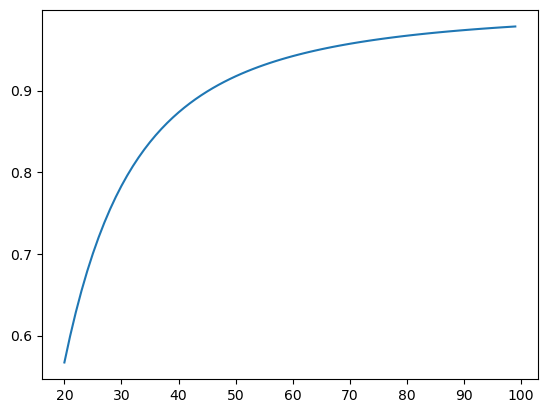

In [26]:
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(20,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]

plt.plot(ys,ps)

### Update DB collection "hit_results"

In [67]:
''' Update all non-disposed hits in the database with data collected from MTurk '''
""" Rejected assignments are ignored """

# we continued at 344!!!

APPROVE_PAYMENT = False # Set to true if automatically approve payment 

# for hit in hit_result_collection.find({'answers': []}):
for hit in hit_result_collection.find({'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}}):
    # iterating over hits previously sent to MTurk
    print('Updating',hit['_id'],end='\r')

    try:
        hit_result_collection.update_one(
            {'_id': hit['_id']},
            {
                "$set": {
                    "hit": mt.client.get_hit(HITId = hit['_id'])['HIT'],
                    'answers': mt.get_hit_answers(hit['_id'], approve=APPROVE_PAYMENT)
                }
            })
    except Exception as e:
        print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')
        continue
print('Done'+(' '*100))


Following exception occurred for hit 3THR0FZ96WRCINKMS5SPWCYMLAXLON: you are over your space quota, using 514 MB of 512 MB, full error: {'ok': 0, 'errmsg': 'you are over your space quota, using 514 MB of 512 MB', 'code': 8000, 'codeName': 'AtlasError'}

Following exception occurred for hit 3YOAVL4CB7FSJJR8OM4PQT3FJSXZ42: you are over your space quota, using 514 MB of 512 MB, full error: {'ok': 0, 'errmsg': 'you are over your space quota, using 514 MB of 512 MB', 'code': 8000, 'codeName': 'AtlasError'}



KeyboardInterrupt: 

In [ ]:
# Extract Pubhealthtab and safe as json




In [298]:
# REJECT SPECIFIC ASSIGNMENT

hit_id = "33IXYHIZCCGK5ALPOL7OC45ZBGV2EM"
assignment_id_rej = "3D4CH1LGEIRWBS095RHTAEUF5JXG9H"
print('Rejecting',hit_id,end='\r')

try: 
    hit_assignmentsList = mt.client.list_assignments_for_hit(
        HITId=hit_id,
    )

    assignments = hit_assignmentsList['Assignments']

#         Get details and results of each Assignment and add to answers array
    answers = []
    for assignment in assignments:
        worker_id = assignment['WorkerId']
        assignment_id = assignment['AssignmentId']

        if assignment_id == assignment_id_rej:
            response = mt.client.reject_assignment(
                AssignmentId=assignment_id,
#                 RequesterFeedback='Poor explanations, e.g. "Claim 3a. is false and is well-formed, grammatically correct and has...".'
                RequesterFeedback='Poor answers, assignment will be rejected and worker blocked.'
            )
            print(f"Rejection successful for assignment {assignment_id}")

except Exception as e:
    print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')


Rejection successful for assignment 3D4CH1LGEIRWBS095RHTAEUF5JXG9H


In [335]:
# Delete specific hit 
# hit_id = "30ZKOOGW334AQCMHPC5OB253YVJA1I"
# hit_id = "3LG268AV4F419U2A3BMPDCD7N9VREC"
# hit_id = "37M4O367WQGAGVWPN2X5NJDK4TXM5I"
# hit_id = "304QEQWK0WIZLRV03C66YS6YIL20OR"

mt.client.update_expiration_for_hit(HITId = hit_id, ExpireAt=datetime(2018, 4, 10, 7, 22, 15))
mt.client.delete_hit(HITId = hit_id)
print('Removed',hit_id)

RequestError: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1683621715351)

In [288]:
### REJECT ASSIGNMENTS

for hit in hit_result_collection.find({}):
    # iterating over hits previously sent to MTurk
    print('Rejecting',hit['_id'],end='\r')
    
    try: 
        hit_assignmentsList = mt.client.list_assignments_for_hit(
            HITId=hit['_id'],
#             AssignmentStatuses=['ReviewAble']
        )

        assignments = hit_assignmentsList['Assignments']
        
#         Get details and results of each Assignment and add to answers array
        answers = []
        for assignment in assignments[:1]:
            worker_id = assignment['WorkerId']
            assignment_id = assignment['AssignmentId']
            
            response = mt.client.reject_assignment(
                AssignmentId=assignment_id,
                RequesterFeedback='Poor answers, assignment will be rejected and worker blocked.'
            )
            print(f"Rejection successful for assignment {assignment_id}",end='\n\n')
        
    except Exception as e:
        print(f"Following exception occurred for hit {hit['_id']}: {e}",end='\n\n')
        continue
print('Done'+(' '*100))



Following exception occurred for hit 30Y6N4AHZWUWHOOA7GB57UVMMZSDR6: An error occurred (RequestError) when calling the RejectAssignment operation: This operation can be called with a status of: Submitted (1679832357099)

Done                                                                                                    


________

## TODO go over this code later

#### Delete previously sent HITs

In [228]:
query = {'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}}
# query['type'] = "claim_generation"
len(list(hit_result_collection.find(query)))


8

In [276]:
query = {}
# query['hit.NumberOfAssignmentsAvailable'] = 3
query['answers'] = []
query['hit.HITStatus'] = "Disposed"

len(list(hit_result_collection.find(query)))

for hit in hit_result_collection.find(query): 
    hit_result_collection.delete_many({"_id": hit["_id"]})
    print(f"HIT with id {hit['_id']} deleted.")


HIT with id 3HFWPF5ALGHA0BMQTG5YKVE6HM13SX deleted.
HIT with id 3O0M2G5VDD0DDS9VKOAQD51M3Y9499 deleted.
HIT with id 3566S7OX6KHS7AOJI9T41B3DWOB17H deleted.
HIT with id 35JDMRECDB7AK4TWN0SDE8Z0K0YGEI deleted.
HIT with id 39HYCOOPLVJ5K8BI28FOLV1CGA9DMU deleted.


In [275]:
""" If you set 'force' to TRUE, it will abort mission and force an expiry in all HITs and then delete them.
If you only want to remove the completed ones (make them Disposed so the update routine won't loop through tons of
HITs), keep it as FALSE."""

force = True

while True:
    ''' Dispose all hits in the database '''
    query = {'hit.HITStatus': {'$not': {'$eq': 'Disposed'}}} # orginally for non-disposed HITs
#     query["type"] = "claim_generation"
#     query = {'timestamp': {'$gte': datetime.datetime(2021, 6, 29)}}
    
    if not force:
        query['hit.NumberOfAssignmentsPending'] = 0
        query['hit.NumberOfAssignmentsAvailable'] = 0
    elif force:
        pass
#         query['hit.NumberOfAssignmentsPending'] = 0
#         query['hit.NumberOfAssignmentsCompleted'] = 0
    
    hit_result_collection_list = list(hit_result_collection.find(query))
    print(f"Length of retrieved HITs ", len(hit_result_collection_list))
    
    if (not force and len(hit_result_collection_list) == 0) or (force and mt.client.list_hits()['NumResults']==0):
        print('Finished')
        break
        
    for hit in hit_result_collection_list:
        try:
            mt.client.update_expiration_for_hit(HITId = hit['_id'], ExpireAt=datetime(2018, 4, 10, 7, 22, 15))
            mt.client.delete_hit(HITId = hit['_id'])
            print('Removed',hit['_id'])
        except Exception as e:
            print(hit['_id'], e)
            
            if force:
                print("force")
                try:
                    mt.client.update_expiration_for_hit(HITId = hit['_id'], ExpireAt=datetime(2018, 4, 10, 7, 22, 15))
                    mt.client.get_hit(HITId = hit['_id'])
                    mt.client.delete_hit(HITId = hit['_id'])
                    print('Removed',hit['_id'])
                except Exception as e:
                    pass
#                     print(hit['_id'],e)
                    
#                     if status == 'Reviewable':
#                     assignments = mt.client.list_assignments_for_hit(HITId=hit['_id'], AssignmentStatuses=['Reviewable'])
#                     if assignments['NumResults'] > 0:
#                         for assign in assignments['Assignments']:
#                             mt.client.approve_assignment(AssignmentId=assign['AssignmentId'])
#                     try:
#                         mt.client.delete_hit(HITId=hit['_id'])
#                     except Exception as e:
#                         pass
#                         print(hit['_id'],e)
            continue
    break
    

Length of retrieved HITs  4
Removed 3S8A4GJREA1PPMQC6D812LAXQIO6V4
Removed 33BFF6QPJ8937S3ZDLFZHKHRN0O3W5
Removed 3BVS8WK9R7TQ9SN73XQQYC6VWH3BIX
33Q5P9PUTWKVEN4NH1A79RF3AGXZCJ An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679655379444)
force


In [160]:
hit_list = mt.client.list_hits()
print(f"Length of retrieved hits: {len(hit_list['HITs'])}")
force = True

for hit in hit_list["HITs"]:
    hitid = hit["HITId"]
    try:
        mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2018, 1, 1))
        mt.client.get_hit(HITId = hitid)
        mt.client.delete_hit(HITId = hitid)
        print('Removed',hitid)
    except Exception as e:
        print(f"Following error occured while deleting HIT {hitid}, lets continue: {e}.")
        if force:
            try:
                mt.client.update_expiration_for_hit(hitid, ExpireAt=datetime(2017, 1, 1))
                mt.client.delete_hit(HITId = hitid)
                print('Removed', hitid)
            except Exception as e:
                pass
#                 print(hit['_id'],e)
        continue


Length of retrieved hits: 10
Following error occured while deleting HIT 39HYCOOPLVJ5K8BI28FOLV1CGA9DMU, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568928220).
Following error occured while deleting HIT 35JDMRECDB7AK4TWN0SDE8Z0K0YGEI, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568930537).
Following error occured while deleting HIT 3566S7OX6KHS7AOJI9T41B3DWOB17H, lets continue: An error occurred (RequestError) when calling the DeleteHIT operation: This HIT is currently in the state 'Unassignable'.  This operation can be called with a status of: Reviewing, Reviewable (1679568932272).
Following error occured while deleting HIT 3O0M2G5VDD0DDS9VKOAQD51M3Y9499,

KeyboardInterrupt: 

#### Delete specific Task

In [274]:
force = True
query = {}

while True:
    ''' Dispose all hits in the database '''
    
    if not force:
        query['hit.NumberOfAssignmentsPending'] = 0
        query['hit.NumberOfAssignmentsAvailable'] = 0
    elif force:
        query['hit.NumberOfAssignmentsPending'] = 0
    
    hit_result_collection_list = list(hit_result_collection.find(query))
    
    if (not force and len(hit_result_collection_list) == 0) or (force and mt.client.list_hits()['NumResults']==0):
        print('Finished')
        break
        
    for hit_id in hit_result_collection_list:
        try:
            mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2018, 1, 1))
            x = mt.client.delete_hit(HITId = hit_id)
            print('Removed',hit_id["_id"])
        except Exception as e:
#             print(hit_id)
            if force:
                print("force")
                try:
                    mt.client.update_expiration_for_hit(HITId = hit_id, ExpireAt=datetime(2017, 1, 1))
                    mt.client.delete_hit(HITId = hit_id)
                    print('Removed',hit_id)
                except Exception as e:
                    pass
#                     print(hit_id,e)
            continue
    break
    

force
force
force
force
force
force
force
force


#### Update HITs

In [ ]:
hitid = '...' # TODO enter HIT_ID you want to update

mt.client.update_expiration_for_hit(HITId = hitid, ExpireAt=datetime(2015, 1, 1))

# mt.client.update_hit_review_status(HITId = hitid, Revert=True)
# mt.client.update_hit_type_of_hit(HITId = hitid, HITTypeId='1623495307575')

# mt.get_hit_answers(hitid, approve=True)
pprint(mt.client.get_hit(HITId = hitid))

### Preparing html tables for UI

In [ ]:
with open(data_folder + "TaskSets/task_sets_en_table.json",'r') as f:
    task_sets = json.load(f)
    
subset = []
for task_set in task_sets: 
    for task in task_set['taskSet']: 
        if (task['table']['header_horizontal']!=[] and any(task['table']['header_horizontal'])) or \
        (task['table']['header_vertical']!=[] and any(task['table']['header_vertical'])): 
            subset.append(task)
            
len(subset)

In [ ]:
from lxml import html
from lxml.etree import tostring


def del_col_row(table, row_i = None, col_i = None):
    """remove columns and rows from table"""

    if type(table)==str:
        table = html.fragment_fromstring(table)
        
    # remove column i
    if col_i != None:
        for row in table.getchildren()[0].iterchildren():
            row.remove(row.getchildren()[col_i])
        
    # remove row i
    if row_i != None:
        for index, row in zip(range(len(table.getchildren()[0].getchildren())), table.getchildren()[0].iterchildren()):
            if index == row_i:
                row.getparent().remove(row)
    
    return table 


In [ ]:
# EXAMPLE 1

url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")

table = tables[3]

# TODO replace in function del_col_row() e.g. table.getchildren() by table.getchildren()[0].getchildren()
# drop columns and rows unnecessary 
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

for i in range(8):
    table = html.tostring(del_col_row(str(table), row_i = 2)).decode('utf-8')
for i in range(6):
    table = html.tostring(del_col_row(str(table), row_i = 9)).decode('utf-8')
for i in range(35):
    table = html.tostring(del_col_row(str(table), row_i = 13)).decode('utf-8')
    
# BeautifulSoup(table)


In [ ]:
# EXAMPLE 2

url = "https://www.cdc.gov/flu/about/burden/index.html"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")

table = tables[0]

# drop columns and rows unnecessary 
# table = html.tostring(del_col_row(str(table), col_i = None)).decode('utf-8')

for i in range(8):
    table = html.tostring(del_col_row(str(table), row_i = 0)).decode('utf-8')
    
table = html.tostring(del_col_row(str(table), col_i = 2)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 3)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 4)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 5)).decode('utf-8')

# Delete second header row.. 
table = html.fragment_fromstring(table)
table.getchildren()[1].remove(table.getchildren()[1].getchildren()[1])
# table.getchildren()[1].remove(table.getchildren()[1].getchildren()[0])

table = html.tostring(table).decode('utf-8')


In [ ]:
# EXAMPLE 3

url = "https://www.macrotrends.net/countries/AUS/australia/crime-rate-statistics"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[1]


In [ ]:
# EXAMPLE 4

url = "https://www.cebm.net/covid-19/global-covid-19-case-fatality-rates"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[0]


In [ ]:
# EXAMPLE 5

url = "https://www.nimh.nih.gov/health/statistics/suicide.shtml"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[0]

for i in range(5):
    table = html.tostring(del_col_row(str(table), row_i = 5)).decode('utf-8')


In [ ]:
# Table Test

url = "https://en.wikipedia.org/wiki/Demographics_of_the_United_States"
resp = requests.get(url)
page = BeautifulSoup(resp.text, 'html.parser')
tables = page.findAll("table")
table = tables[23]

for i in range(5):
    table = html.tostring(del_col_row(str(table), row_i = 10)).decode('utf-8')

table = html.tostring(del_col_row(str(table), row_i = 0)).decode('utf-8')
table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

table = html.fragment_fromstring(table)
table.getchildren()[0].getchildren()[0].remove(table.getchildren()[0].getchildren()[0].getchildren()[4])

for row in table.getchildren()[0].iterchildren():
    if row.getchildren():
#         print(f"This: {html.tostring(row.getchildren()[0])}")
        row.remove(row.getchildren()[2])
        
# table = html.tostring(del_col_row(str(table), col_i = 0)).decode('utf-8')

table = html.tostring(table).decode('utf-8')
BeautifulSoup(table)


In [ ]:
# task = subset[100]

# if not task['table']['caption']:
#     task['table']['caption'] = ''
# html_table = task['table']['html_table']

html_table_bs = BeautifulSoup(table)
# html_table_bs = table
html_table_bs = _remove_attrs(html_table_bs)
_remove_img(html_table_bs)
_remove_caption(html_table_bs)

for tag in html_table_bs.findAll(["table", "th", "td"]):
    tag['style'] = "border: 1px solid black;"

html_table = str(html_table_bs).replace("\n", "").replace("'", "\'")
# html_table_bs = BeautifulSoup(html_table)

print(html_table)


In [ ]:
# Load taskset for table task for MOCK HTML page


html_table = task_sets[i]["taskSet"][entry]['table']['html_table']
html_table = html_table.replace("\n", "")
html_table = html_table.replace("'", "\'")
# html_table = html_table.replace("%", "\%")
# html_table = html_table.replace("", "\'")

html_table_bs = BeautifulSoup(html_table)
html_table_bs = _remove_attrs(html_table_bs)
html_table_bs

### 3. Updating HITs

In [ ]:
html_table_list = []
tags = []

for table_list in test_data["tables_wikipedia_references"]:
    if table_list and type(table_list)!=float:
        for table in table_list: 
            if table and "html_table" in table and type(table["html_table"])==str:
                soup = BeautifulSoup(table["html_table"])
                tags.extend([tag.name for tag in soup.find_all()])
                html_table_list.append(table["html_table"])
            
len(html_table_list)

In [ ]:
tags = list(set(tags))
tags

#### Send some taskSets again

In [ ]:
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_1.json', "r") as file: 
    taskset_1 = json.load(file)
    
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_3.json', "r") as file: 
    taskset_3 = json.load(file)


In [ ]:
relevant_taskSets = []

for entry in taskset_1+taskset_3: 
    for task in entry["taskSet"]:
        if task["claim_db_id"] == "6072bd2a000ca92c09d11fb5":
            task["table"]["header_horizontal"] = []
            task["g_id"] = 3
            relevant_taskSets.append(entry)
            
        elif task["claim_db_id"] == "6072bd2d000ca92c09d145b8":
            task["g_id"] = 3
            relevant_taskSets.append(entry)

    

In [ ]:
with open(r'./data/production/TaskSets/final_table_annotation/tasksets_table_annotation_faultyHITs_updated.json', "w", encoding="utf-8") as file: 
    json.dump(relevant_taskSets, file, indent=4)
